# **Task 2: Lookalike Model**

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

## **Preparing Dataset**

In [2]:
#loading the dataset
Customers_df= pd.read_csv("C:/Users/User/Desktop/data science/Zeotap Assignment/data/Customers.csv")
Products_df=pd.read_csv("C:/Users/User/Desktop/data science/Zeotap Assignment/data/Products.csv")
Transaction_df=pd.read_csv("C:/Users/User/Desktop/data science/Zeotap Assignment/data/Transactions.csv")

In [3]:
merged_df=Transaction_df.merge(Products_df, on='ProductID').merge(Customers_df, on='CustomerID')

In [4]:
merged_df.head(2)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,ProductName,Category,Price_y,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Brittany Harvey,Asia,2024-09-04


In [5]:
merged_df.shape

(1000, 13)

In [6]:
merged_df['CustomerID'].nunique()

199

In [7]:
# Customer behavior 
cust_behavior = merged_df.groupby('CustomerID').agg({
    'TotalValue':'sum', # total spendingf
    'Quantity':'sum', # total products bought
    'ProductID': 'nunique', #unique products bought
    'Region': 'first',
    'Category': lambda x: x.mode()[0] # top category
}).reset_index()

cust_behavior

,CustomerID,TotalValue,Quantity,ProductID,Region,Category
0,C0001,3354.52,12,5,South America,Electronics
1,C0002,1862.74,10,4,Asia,Clothing
2,C0003,2725.38,14,4,South America,Home Decor
3,C0004,5354.88,23,8,South America,Books
4,C0005,2034.24,7,3,Asia,Electronics
...,...,...,...,...,...,...
194,C0196,4982.88,12,3,Europe,Home Decor
195,C0197,1928.65,9,3,Europe,Electronics
196,C0198,931.83,3,2,Europe,Clothing
197,C0199,1979.28,9,4,Europe,Electronics


In [8]:
# renaming columns 
cust_behavior.rename(columns={
    'TotalValue' : 'TotalSpending',
    'Quantity': 'TotalProducts',
    'ProductID': 'UniqueProducts',
    'Category' : 'PreferredCategory'
},inplace=True)
cust_behavior.head(2)

,CustomerID,TotalSpending,TotalProducts,UniqueProducts,Region,PreferredCategory
0,C0001,3354.52,12,5,South America,Electronics
1,C0002,1862.74,10,4,Asia,Clothing


In [9]:
cust_behavior = pd.get_dummies(cust_behavior, columns=['Region', 'PreferredCategory'], drop_first=True)
cust_behavior.head(2)

,CustomerID,TotalSpending,TotalProducts,UniqueProducts,Region_Europe,Region_North America,Region_South America,PreferredCategory_Clothing,PreferredCategory_Electronics,PreferredCategory_Home Decor
0,C0001,3354.52,12,5,False,False,True,False,True,False
1,C0002,1862.74,10,4,False,False,False,True,False,False


## **Similarity Score**

In [11]:
scaler=StandardScaler()
scaled_data=scaler.   fit_transform(cust_behavior.drop(columns=['CustomerID']))

In [12]:
similarity_matrix=cosine_similarity(scaled_data)

In [26]:
similarity_df=pd.DataFrame(similarity_matrix, index=cust_behavior['CustomerID'], columns=cust_behavior['CustomerID'])

similarity_df.iloc[:2, :5]


CustomerID,C0001,C0002,C0003,C0004,C0005
CustomerID,,,,,
C0001,1.000000,-0.304866,0.174026,0.285215,0.520766
C0002,-0.304866,1.000000,-0.235343,-0.394134,0.120782


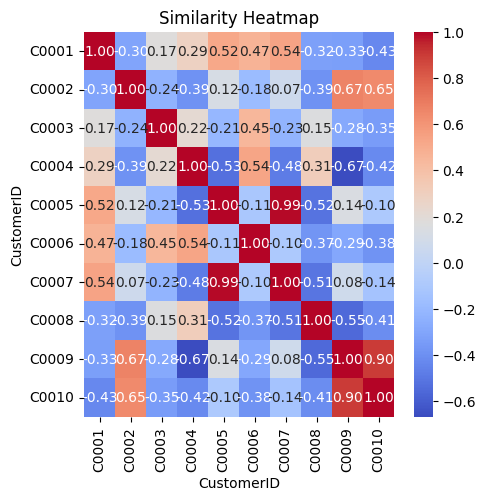

In [49]:
plt.figure(figsize=(5, 5))
sns.heatmap(similarity_df.iloc[:10, :10], annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Similarity Heatmap")
plt.show()

## **Recommendations**

In [15]:
recommendations = {}

for cust in cust_behavior['CustomerID'][:20]: #first 20 customer
    similar_cust=similarity_df[cust].sort_values(ascending=False).iloc[1:4]
    recommendations[cust]=list(zip(similar_cust.index, similar_cust.values))
    

In [16]:
recommendation_df=pd.DataFrame([
    {'CustomerID':customer, 'Recommendations': rec}
    for customer, rec in recommendations.items()
])

In [17]:
recommendation_df.head(2)

,CustomerID,Recommendations
0,C0001,"[(C0048, 0.9947610394254752), (C0190, 0.989569..."
1,C0002,"[(C0088, 0.9799376691247775), (C0092, 0.949378..."


In [20]:
recommendations_expanded = recommendation_df.explode('Recommendations')
recommendations_expanded[['RecommendedCustomer', 'SimilarityScore']] = pd.DataFrame(
    recommendations_expanded['Recommendations'].tolist(), index=recommendations_expanded.index
)

In [27]:
recommendations_expanded.head(3)

,CustomerID,RecommendedCustomer,SimilarityScore
0,C0001,C0048,0.994761
0,C0001,C0190,0.989570
0,C0001,C0184,0.982728


In [23]:
recommendations_expanded = recommendations_expanded.drop(columns=['Recommendations'])

In [50]:
recommendations_expanded.to_csv('Yuzia_Haque_Lookalike.csv', index=False)